# Target Time Series Analysis Project!

## Goal: given a large dataset, create a machine learning pipeline to predict product delivery times.

### Lets keep a couple things in mind:
#### - Our data came in multiple csv files:
    - customers.csv
    - geolocation.csv
    - order_items.csv
    - orders.csv
    - payments.csv
    - products.csv
    - sellers.csv
#### - We will be using:
    - orders.csv
    - order_items.csv
    - customers.csv
    - products.csv
    - sellers.csv
#### - We want to use an ARIMA model, which means we need to make sure:
    - our input dataset has one single time series column in 'datetime' index
    - our data is stationary (stats dont change as the model is training)
    - we hadle missing values as ARIMA can't process them

# **Overall outline of this project**(subject to change)**:**
## 1. Pre-process each dataset 
    - handle missing, duplicate, and outlier values
    - feature engineer new descriptive features that can be of use when training our model
    - encode features using a variety of techniques 
## 2. Combine all datasets and perform EDA on larger dataset
    - identify and display relationships across features using visualizations 
## 3. Prepare larger dataset for model
    - same pre-processing checklist as before
## 4. Model training & eval
    - fit ARIMA model and evaluate metrics
    - fine tune using grid search (this is different in ARIMA than other models so pay close attention to this)
    - re-evaluate model & metrics
## 5. Present Insights
    - interpret results in context of real-world
    - draw meaningful conclusions for several departments 
    - draft report to showcase findings in a simple manner
    
#### Let's start by loading, cleaning, and preparing each file in their own df. We'll thoroughly clean and preprocess each one. Then, we will combine them all and do a final review of the data as one big df to ensure everything is flowing together before starting EDA.

<div class="alert alert-block alert-info">
<b>What is an ARIMA Model!?:</b> Autoregressive Integrated Moving Average (ARIMA) models are widely used for time series forecasting. <b>For more info, click <i>here</i> </b>
</div>

Dont forget to load your dependencies!

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [160]:
# Geolocation.csv

geolocation_df = pd.read_csv('target_data/geolocation.csv')
geolocation_df.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [161]:
geolocation_df.shape

(1000163, 5)

In [162]:
geolocation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [163]:
geolocation_df.isna().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

In [164]:
geolocation_df.describe(include='object')

,geolocation_city,geolocation_state
count,1000163,1000163
unique,8011,27
top,sao paulo,SP
freq,135800,404268


In [165]:
geolocation_df.describe()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,1.000163e+06,1.000163e+06,1.000163e+06
mean,3.657417e+04,-2.117615e+01,-4.639054e+01
std,3.054934e+04,5.715866e+00,4.269748e+00
min,1.001000e+03,-3.660537e+01,-1.014668e+02
25%,1.107500e+04,-2.360355e+01,-4.857317e+01
50%,2.653000e+04,-2.291938e+01,-4.663788e+01
75%,6.350400e+04,-1.997962e+01,-4.376771e+01
max,9.999000e+04,4.506593e+01,1.211054e+02


#### Lets take a sec here to plot a scatterplot on a to visualize where our customers are located

Here we are going to use a library that branches of pandas and matplotlib to plot geographical data. Below we are importing the libs, defing our coordinate reference system (CRS) and the xy points.

/Users/johnathangarcia/Documents/new_projects/data_science/time_series_models/target/myenv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

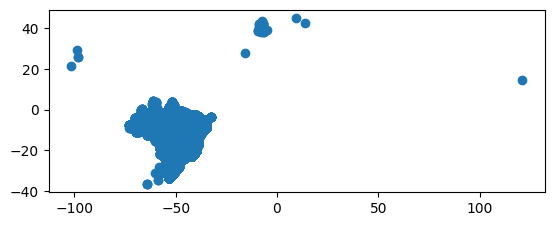

In [166]:
from shapely.geometry import Point, Polygon
import geopandas as gpd
import geodatasets as gds

crs={'init':'epsg:4326'}

geometry = [Point(xy) for xy in zip(geolocation_df['geolocation_lng'], geolocation_df['geolocation_lat'])]
geodata = gpd.GeoDataFrame(geolocation_df, crs=crs, geometry=geometry)

geodata.plot()

#### Lets make this a little easier to read

/Users/johnathangarcia/Documents/new_projects/data_science/time_series_models/target/myenv/lib/python3.12/site-packages/contextily/plotting.py:298: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  draw()
/Users/johnathangarcia/Documents/new_projects/data_science/time_series_models/target/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


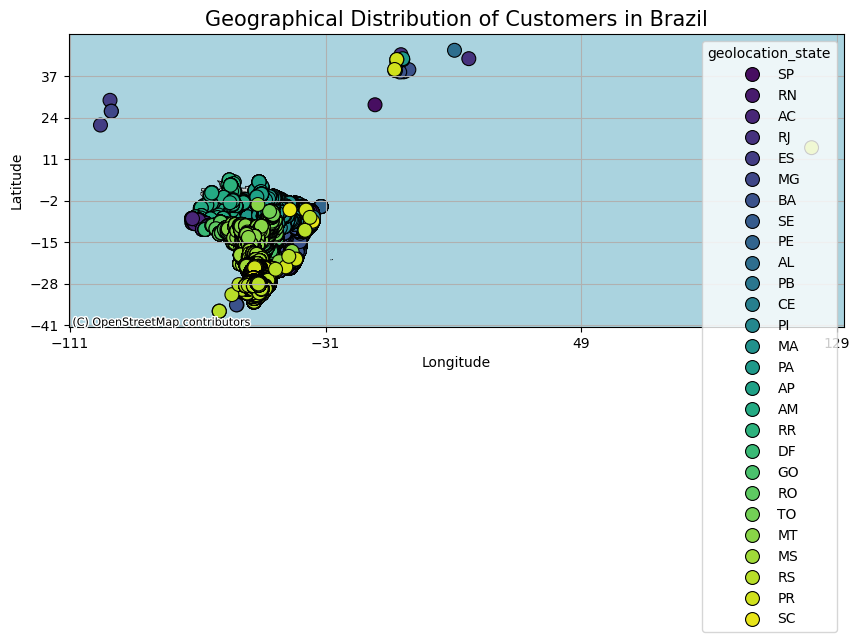

In [167]:
gdf = gpd.GeoDataFrame(geolocation_df, geometry=gpd.points_from_xy(geolocation_df['geolocation_lng'], geolocation_df['geolocation_lat']))

bra_shapefile_path = '/Users/johnathangarcia/Documents/new_projects/data_science/time_series_models/target/BRA_adm1.shp'
brazil = gpd.read_file(bra_shapefile_path)

# Create the base plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the shapefile data
brazil.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)  # Brazil map as the background

# Plot the customer data
sns.scatterplot(data=gdf, x=gdf.geometry.x, y=gdf.geometry.y, hue='geolocation_state', palette='viridis', s=100, ax=ax, edgecolor='black')

xmin, xmax = -1.014668e+02 - 10, 1.211054e+02 + 10
ymin, ymax = -3.660537e+01 - 5, 4.506593e+01 + 5
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

ax.set_xticks(range(int(xmin), int(xmax), int((xmax-xmin)/3)))
ax.set_yticks(range(int(ymin), int(ymax), int((ymax-ymin)/7)))

import contextily as ctx
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Additional Plot Customizations
ax.set_title('Geographical Distribution of Customers in Brazil', fontsize=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


#### Okay this is better but we still seem so far away from most of the data. 

The reason for this is the outliers that are dragging the scales out. This is an example of something we'd fix in this clean/preprocess step.

# Now that we've gotten a taste, lets start Step 1 of our pipeline process.

In [168]:
customers = pd.read_csv('target_data/customers.csv')
orders = pd.read_csv('target_data/orders.csv')
order_items = pd.read_csv('target_data/order_items.csv')
products = pd.read_csv('target_data/products.csv')

dfs = [customers, orders, order_items, products]
for df in dfs:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  obje

# Lets take a closer look at customers.

In [169]:
customers.describe(include='all')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441.000000,99441,99441
unique,99441,96096,NaN,4119,27
top,06b8999e2fba1a1fbc88172c00ba8bc7,8d50f5eadf50201ccdcedfb9e2ac8455,NaN,sao paulo,SP
freq,1,17,NaN,15540,41746
mean,NaN,NaN,35137.474583,NaN,NaN
std,NaN,NaN,29797.938996,NaN,NaN
min,NaN,NaN,1003.000000,NaN,NaN
25%,NaN,NaN,11347.000000,NaN,NaN
50%,NaN,NaN,24416.000000,NaN,NaN
75%,NaN,NaN,58900.000000,NaN,NaN


In [170]:
customers.isna().sum()


customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

#### There are no missing values, but there are still few things we need to do:
> - get rid of duplicates in 'customer_unique_id'
> - get rid of customer_id

In [171]:
customers = customers.drop_duplicates(subset=['customer_unique_id'])
# customers.drop('customer_id', axis=1, inplace=True)
customers.describe(include='all')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,96096,96096,96096.000000,96096,96096
unique,96096,96096,NaN,4118,27
top,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,NaN,sao paulo,SP
freq,1,1,NaN,14971,40295
mean,NaN,NaN,35185.761832,NaN,NaN
std,NaN,NaN,29801.656868,NaN,NaN
min,NaN,NaN,1003.000000,NaN,NaN
25%,NaN,NaN,11405.000000,NaN,NaN
50%,NaN,NaN,24440.000000,NaN,NaN
75%,NaN,NaN,59035.500000,NaN,NaN


# Lets look at Orders now.

In [172]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [173]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [174]:
orders.describe(include='all')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2018-04-11 10:48:14,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 23:38:46,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


Lets start by getting rid of rows that are missing timestamp info because they provide no value in helping us predict delivery time.

We can also get rid of rows that have not yet been delivered since we want to be able to calculate the delivery time as a feature for our model.

In [175]:
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  object        
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](4), object(4)
memory usage: 6.1+ MB


In [176]:
orders = orders.dropna(subset=['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96461 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96461 non-null  object        
 1   customer_id                    96461 non-null  object        
 2   order_status                   96461 non-null  object        
 3   order_purchase_timestamp       96461 non-null  object        
 4   order_approved_at              96461 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96461 non-null  datetime64[ns]
 6   order_delivered_customer_date  96461 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96461 non-null  datetime64[ns]
dtypes: datetime64[ns](4), object(4)
memory usage: 6.6+ MB


In [177]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


#### Perfect! Lets organize these by date now.

In [178]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders.sort_values(by='order_purchase_timestamp', inplace=True)
orders.head()

/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/1510523924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/1510523924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders.sort_values(by='order_purchase_timestamp', inplace=True)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04
93285,3b697a20d9e427646d92567910af6d57,355077684019f7f60a031656bd7262b8,delivered,2016-10-03 09:44:50,2016-10-06 15:50:54,2016-10-23 14:02:13,2016-10-26 14:02:13,2016-10-27
28424,be5bc2f0da14d8071e2d45451ad119d9,7ec40b22510fdbea1b08921dd39e63d8,delivered,2016-10-03 16:56:50,2016-10-06 16:03:44,2016-10-21 16:33:46,2016-10-27 18:19:38,2016-11-07
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
97979,a41c8759fbe7aab36ea07e038b2d4465,6f989332712d3222b6571b1cf5b835ce,delivered,2016-10-03 21:13:36,2016-10-05 03:11:49,2016-10-25 11:57:59,2016-11-03 10:58:07,2016-11-29


In [179]:
orders.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,96461,96461,96461,96461,96461
mean,2018-01-01 23:53:26.642249216,2018-01-02 10:10:06.480142336,2018-01-05 05:21:04.508827392,2018-01-14 13:17:13.228102400,2018-01-25 17:33:14.236012544
min,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-04 00:00:00
25%,2017-09-14 09:28:28,2017-09-14 14:30:14,2017-09-18 16:52:19,2017-09-25 22:31:59,2017-10-05 00:00:00
50%,2018-01-20 19:59:42,2018-01-22 13:49:00,2018-01-24 16:19:03,2018-02-02 19:50:56,2018-02-16 00:00:00
75%,2018-05-05 18:33:24,2018-05-06 10:30:49,2018-05-08 14:33:00,2018-05-15 23:08:54,2018-05-28 00:00:00
max,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00


#### This is looking alot better already. I think it'd be beneficial to add the following columns:
- estimated delivery time
- actual delivery time
- delivery delay
This is because we can get from meaningful data from the mean, median, and mode of the length of delivery. We can also use these values to get rid of outliers that may skew our model. 

<div class="alert alert-block alert-info">
<b>Note:</b> We could have calculated the median before removing na rows and filled them with the median value. However, we have enough real data points in this dataset for the purposes of our model.
</div>

In [180]:
# actual delivery time
orders['actual_delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days
# est delivery time
orders['estimated_delivery_time'] = (orders['order_estimated_delivery_date'] - orders['order_purchase_timestamp']).dt.days
# delivery delay
orders['delivery_delay'] = orders['actual_delivery_time'] - orders['estimated_delivery_time']

/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/2792866866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['actual_delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days
/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/2792866866.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['estimated_delivery_time'] = (orders['order_estimated_delivery_date'] - orders['order_purchase_timestamp']).dt.days
/var/folders/9k

In [181]:
orders.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,actual_delivery_time,estimated_delivery_time,delivery_delay
count,96461,96461,96461,96461,96461,96461.000000,96461.000000,96461.000000
mean,2018-01-01 23:53:26.642249216,2018-01-02 10:10:06.480142336,2018-01-05 05:21:04.508827392,2018-01-14 13:17:13.228102400,2018-01-25 17:33:14.236012544,12.093582,23.372378,-11.278797
min,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-04 00:00:00,0.000000,2.000000,-146.000000
25%,2017-09-14 09:28:28,2017-09-14 14:30:14,2017-09-18 16:52:19,2017-09-25 22:31:59,2017-10-05 00:00:00,6.000000,18.000000,-16.000000
50%,2018-01-20 19:59:42,2018-01-22 13:49:00,2018-01-24 16:19:03,2018-02-02 19:50:56,2018-02-16 00:00:00,10.000000,23.000000,-12.000000
75%,2018-05-05 18:33:24,2018-05-06 10:30:49,2018-05-08 14:33:00,2018-05-15 23:08:54,2018-05-28 00:00:00,15.000000,28.000000,-7.000000
max,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,209.000000,155.000000,189.000000
std,NaN,NaN,NaN,NaN,NaN,9.551576,8.759744,10.193481


# We can now obviously notice some things we need to take care of.

- outliers need to be dealt with
- perform binning for 'actual_delivery_time' and 'estimated_delivery_time'
- one-hot encoding for 'delivery delay'
- set binned columns to upper bound so easier for model to understand; this way we'll be able to say 'delivery by _' instead of 'delivery in 1-3 days'.
** Always better to overestimate and overdeliver than underestimate and underdeliver **

Customers will be **more** happy if a package is coming **by** a certain date and shows up early compared to a ***window** of a couple days and have the package arrive towards the end of the window**

(from life experience, not based on an objective study)

In [182]:
# catching outliers
def catch_outliers_iqr(df):
    outlier_count = {}
    for column in orders.select_dtypes(include='number'):
        Q1 = orders[column].quantile(.25)
        Q3 = orders[column].quantile(.75)
        IQR = Q3-Q1
        low = Q1 - (1.5*IQR) 
        high = Q3 + (1.5*IQR)
        outliers = orders[(orders[column] < low) | (orders[column] > high)]
        outlier_count[column] = outliers.shape[0]
    return outlier_count

outliers_iqr = catch_outliers_iqr(orders)
outliers_orders = pd.DataFrame(list(outliers_iqr.items()), columns=['Column', '# Outliers'])
outliers_orders



,Column,# Outliers
0,actual_delivery_time,5024
1,estimated_delivery_time,2320
2,delivery_delay,6110


In [183]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96461 entries, 30710 to 88097
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96461 non-null  object        
 1   customer_id                    96461 non-null  object        
 2   order_status                   96461 non-null  object        
 3   order_purchase_timestamp       96461 non-null  datetime64[ns]
 4   order_approved_at              96461 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96461 non-null  datetime64[ns]
 6   order_delivered_customer_date  96461 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96461 non-null  datetime64[ns]
 8   actual_delivery_time           96461 non-null  int64         
 9   estimated_delivery_time        96461 non-null  int64         
 10  delivery_delay                 96461 non-null  int64         
dtypes: datetime64[ns

#### Let's go ahead and plot this to see it visually. 
We can bin the dates to see how delivery times change with seasons.


In [184]:
# bin dates
orders['quarter_label'] = orders['order_purchase_timestamp'].dt.to_period('Q').apply(lambda x: f'Q{x.quarter} {x.year}')
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96461 entries, 30710 to 88097
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96461 non-null  object        
 1   customer_id                    96461 non-null  object        
 2   order_status                   96461 non-null  object        
 3   order_purchase_timestamp       96461 non-null  datetime64[ns]
 4   order_approved_at              96461 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96461 non-null  datetime64[ns]
 6   order_delivered_customer_date  96461 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96461 non-null  datetime64[ns]
 8   actual_delivery_time           96461 non-null  int64         
 9   estimated_delivery_time        96461 non-null  int64         
 10  delivery_delay                 96461 non-null  int64         
 11  quarter_label   

/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/861134862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['quarter_label'] = orders['order_purchase_timestamp'].dt.to_period('Q').apply(lambda x: f'Q{x.quarter} {x.year}')


/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/4145582106.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['delivery_delay'] = orders['delivery_delay'].apply(lambda x: 1 if x>0 else 0)
/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/4145582106.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='delivery_delay', data=orders, palette='Set2')


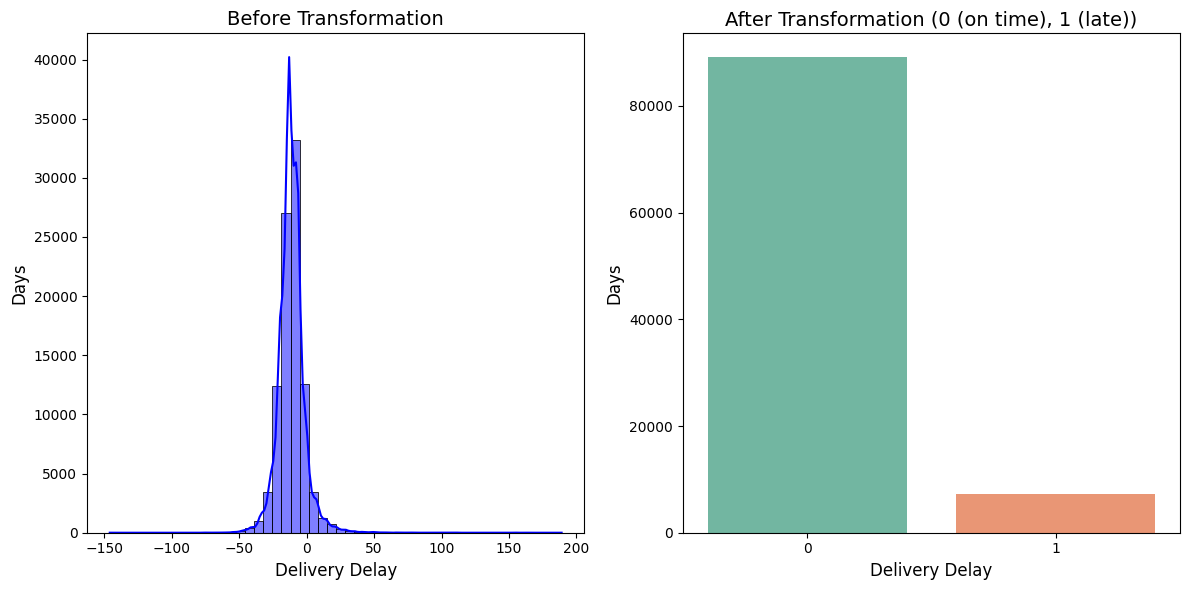

In [185]:
# might as well encode the delivery delay since we're doing this

# b4 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(orders['delivery_delay'], kde=True, bins=50, color='blue')
plt.title('Before Transformation', fontsize=14)
plt.xlabel('Delivery Delay', fontsize=12)
plt.ylabel('Days', fontsize=12)

# one-hot encode
orders['delivery_delay'] = orders['delivery_delay'].apply(lambda x: 1 if x>0 else 0)

# after
plt.subplot(1, 2, 2)
sns.countplot(x='delivery_delay', data=orders, palette='Set2')
plt.title('After Transformation (0 (on time), 1 (late))', fontsize=14)
plt.xlabel('Delivery Delay', fontsize=12)
plt.ylabel('Days', fontsize=12)

plt.tight_layout()
plt.show()

#### Remember that delivery_delay was calculated as follows: actual - estimated. 

#### Therefore, any values<=0 (set to 0) imply the order was delivered early, while values>0 (set to 1) imply the order was delivered late.

#### In other words:
**on-time arrival --> 0**

**late arrival --> 1**

**Note**: The plot will look the same once you run the cell a second time since the data has already been changed instead of copied into a different column.

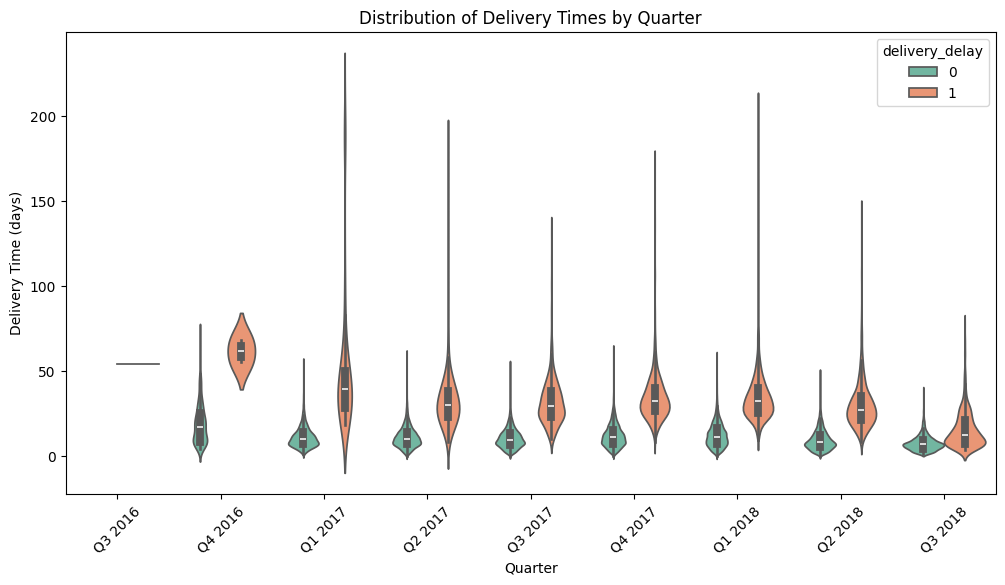

In [186]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='quarter_label', y='actual_delivery_time', data=orders, hue='delivery_delay', palette='Set2', inner='box')

plt.title('Distribution of Delivery Times by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Delivery Time (days)')
plt.xticks(rotation=45)

plt.show()

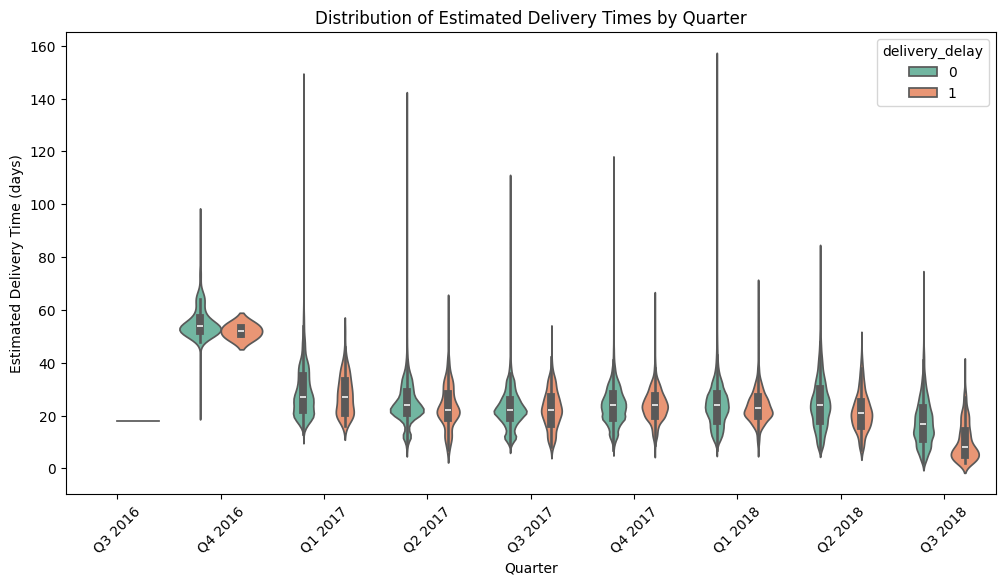

In [187]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='quarter_label', y='estimated_delivery_time', data=orders, hue='delivery_delay', palette='Set2', inner='box')

plt.title('Distribution of Estimated Delivery Times by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Estimated Delivery Time (days)')
plt.xticks(rotation=45)

plt.show()

/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/2422344658.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='quarter_label', y='delivery_delay', data=orders, palette='Set2', inner='box')


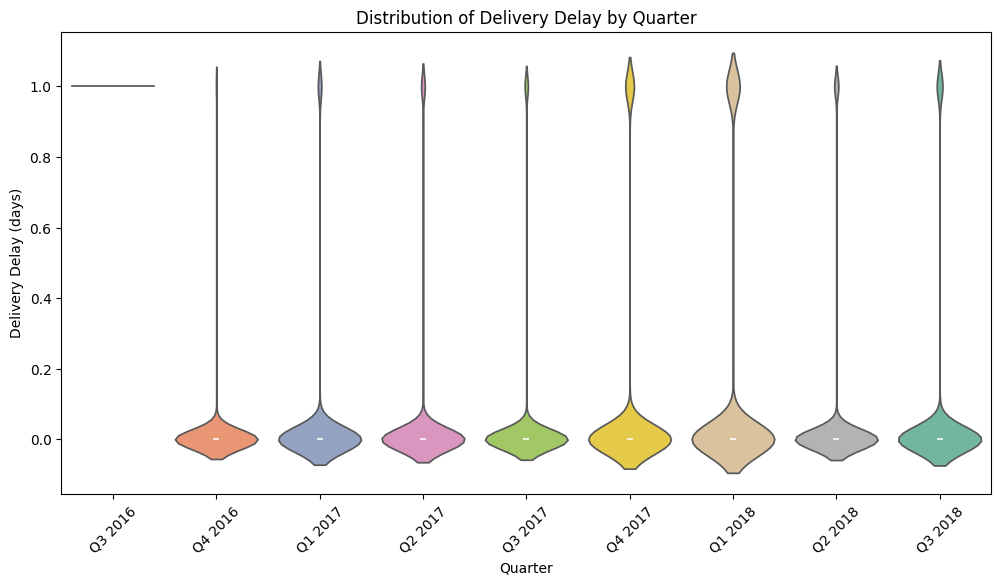

In [188]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='quarter_label', y='delivery_delay', data=orders, palette='Set2', inner='box')

plt.title('Distribution of Delivery Delay by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Delivery Delay (days)')
plt.xticks(rotation=45)

plt.show()

#### Hmmm. It seems to be alot simpler to draw conclusions from these plots when the data is binned in some way. Lets try creating binned versions of the previous two plots.

In [189]:
bins_actual = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, float('inf')]
labels_actual = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51+']

bins_est = [0, 10, 20, 30, 40, 50, 60, 70, 80, float('inf')]
labels_est = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+']

orders['binned_actual_delivery_time'] = pd.cut(orders['actual_delivery_time'], bins=bins_actual, labels=labels_actual, include_lowest=True)
orders['binned_estimated_delivery_time'] = pd.cut(orders['estimated_delivery_time'], bins=bins_est, labels=labels_est, include_lowest=True)

orders.head()

/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/131527509.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['binned_actual_delivery_time'] = pd.cut(orders['actual_delivery_time'], bins=bins_actual, labels=labels_actual, include_lowest=True)
/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/131527509.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['binned_estimated_delivery_time'] = pd.cut(orders['estimated_delivery_time'], bins=bins_est, labels=labels_est, i

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,actual_delivery_time,estimated_delivery_time,delivery_delay,quarter_label,binned_actual_delivery_time,binned_estimated_delivery_time
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,54,18,1,Q3 2016,51+,11-20
93285,3b697a20d9e427646d92567910af6d57,355077684019f7f60a031656bd7262b8,delivered,2016-10-03 09:44:50,2016-10-06 15:50:54,2016-10-23 14:02:13,2016-10-26 14:02:13,2016-10-27,23,23,0,Q4 2016,21-25,21-30
28424,be5bc2f0da14d8071e2d45451ad119d9,7ec40b22510fdbea1b08921dd39e63d8,delivered,2016-10-03 16:56:50,2016-10-06 16:03:44,2016-10-21 16:33:46,2016-10-27 18:19:38,2016-11-07,24,34,0,Q4 2016,21-25,31-40
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25,35,52,0,Q4 2016,31-35,51-60
97979,a41c8759fbe7aab36ea07e038b2d4465,6f989332712d3222b6571b1cf5b835ce,delivered,2016-10-03 21:13:36,2016-10-05 03:11:49,2016-10-25 11:57:59,2016-11-03 10:58:07,2016-11-29,30,56,0,Q4 2016,26-30,51-60


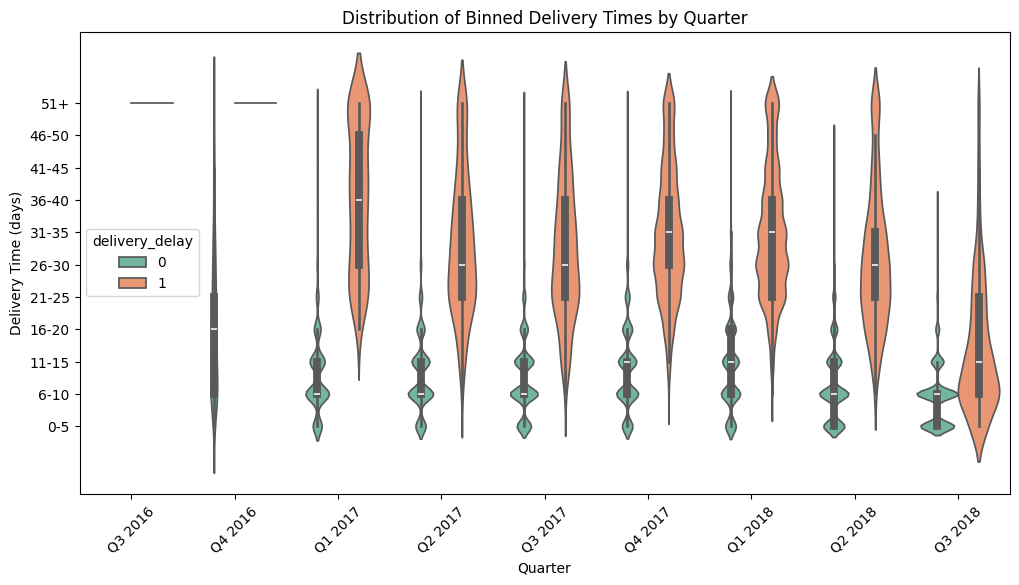

In [190]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='quarter_label', y='binned_actual_delivery_time', data=orders, hue='delivery_delay', palette='Set2', inner='box')

plt.title('Distribution of Binned Delivery Times by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Delivery Time (days)')
plt.xticks(rotation=45)

plt.gca().invert_yaxis()

plt.show()

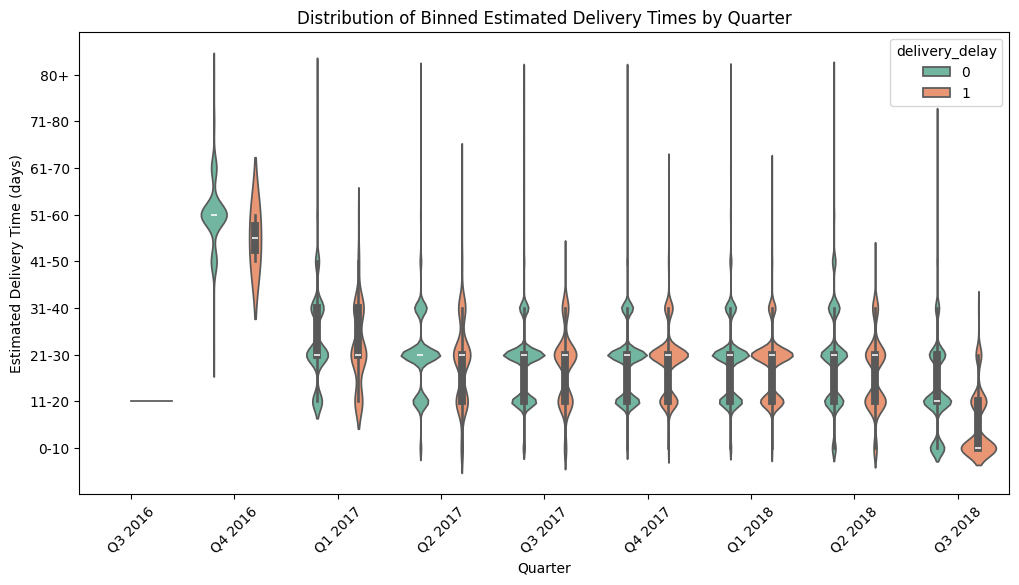

In [191]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='quarter_label', y='binned_estimated_delivery_time', data=orders, hue='delivery_delay', palette='Set2', inner='box')

plt.title('Distribution of Binned Estimated Delivery Times by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Estimated Delivery Time (days)')
plt.xticks(rotation=45)

plt.gca().invert_yaxis()

plt.show()

#### These are definitely alot easier to read. We've done alot with our orders data. Lastly, lets set these bins to the upper bound so the ARIMA model can understand the data easier.

In [192]:
orders['binned_estimated_delivery_time'].value_counts()

binned_estimated_delivery_time
21-30    44105
11-20    30131
31-40    13787
0-10      5176
41-50     2394
51-60      655
61-70      149
80+         33
71-80       31
Name: count, dtype: int64

In [193]:
# lets drop 51-60 and up as those have such little data it seems to be just outliers 
values_to_drop = ['51-60', '61-70', '71-80', '80+']
orders = orders[~orders['binned_estimated_delivery_time'].isin(values_to_drop)]
orders['binned_estimated_delivery_time'].value_counts()

binned_estimated_delivery_time
21-30    44105
11-20    30131
31-40    13787
0-10      5176
41-50     2394
51-60        0
61-70        0
71-80        0
80+          0
Name: count, dtype: int64

In [194]:
orders.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,actual_delivery_time,estimated_delivery_time,delivery_delay
count,95593,95593,95593,95593,95593,95593.000000,95593.000000,95593.000000
mean,2018-01-03 06:14:39.520404224,2018-01-03 16:29:27.999152896,2018-01-06 10:22:02.558712576,2018-01-15 17:40:28.168872192,2018-01-26 16:18:53.706443008,12.011695,23.056050,0.076303
min,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-13 07:45:48,2016-10-04 00:00:00,0.000000,2.000000,0.000000
25%,2017-09-15 13:15:51,2017-09-15 18:25:22,2017-09-19 13:38:01,2017-09-26 21:43:56,2017-10-06 00:00:00,6.000000,18.000000,0.000000
50%,2018-01-21 16:32:05,2018-01-22 14:11:57,2018-01-24 19:08:05,2018-02-02 23:16:58,2018-02-16 00:00:00,10.000000,23.000000,0.000000
75%,2018-05-05 21:00:57,2018-05-06 12:53:26,2018-05-08 14:45:00,2018-05-15 23:33:07,2018-05-28 00:00:00,15.000000,28.000000,0.000000
max,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-05 00:00:00,209.000000,50.000000,1.000000
std,NaN,NaN,NaN,NaN,NaN,9.463593,8.083072,0.265483


In [195]:
orders['binned_actual_delivery_time'].value_counts()

binned_actual_delivery_time
6-10     32689
11-15    21000
0-5      19213
16-20    10547
21-25     5420
26-30     2777
31-35     1544
36-40      866
41-45      614
51+        579
46-50      344
Name: count, dtype: int64

In [196]:
# lets drop 36-40 and up as those have such little data it seems to be just outliers 
values_to_drop = ['36-40', '41-45', '46-50', '51+']
orders = orders[~orders['binned_actual_delivery_time'].isin(values_to_drop)]
orders['binned_actual_delivery_time'].value_counts()

binned_actual_delivery_time
6-10     32689
11-15    21000
0-5      19213
16-20    10547
21-25     5420
26-30     2777
31-35     1544
36-40        0
41-45        0
46-50        0
51+          0
Name: count, dtype: int64

In [197]:
orders.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,actual_delivery_time,estimated_delivery_time,delivery_delay
count,93190,93190,93190,93190,93190,93190.000000,93190.000000,93190.000000
mean,2018-01-03 13:36:49.607468800,2018-01-03 23:48:21.915870720,2018-01-06 15:13:42.217512704,2018-01-15 02:31:07.338437888,2018-01-26 20:24:43.111921664,11.072701,22.919830,0.053836
min,2016-10-03 09:44:50,2016-10-04 09:43:32,2016-10-08 10:34:01,2016-10-13 07:45:48,2016-10-27 00:00:00,0.000000,2.000000,0.000000
25%,2017-09-14 07:13:58.750000128,2017-09-14 12:05:18,2017-09-18 15:14:14,2017-09-25 20:22:13.750000128,2017-10-05 00:00:00,6.000000,18.000000,0.000000
50%,2018-01-21 12:30:12,2018-01-22 13:59:30,2018-01-24 16:50:21.500000,2018-02-02 01:39:50,2018-02-16 00:00:00,10.000000,23.000000,0.000000
75%,2018-05-07 18:23:01,2018-05-08 04:55:02.750000128,2018-05-09 15:48:00,2018-05-16 21:28:33.500000,2018-05-29 00:00:00,15.000000,28.000000,0.000000
max,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-03 12:56:00,2018-09-13 19:24:35,2018-10-05 00:00:00,35.000000,50.000000,1.000000
std,NaN,NaN,NaN,NaN,NaN,6.852891,8.060109,0.225695


/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/3859189763.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=col, data=orders, ax=axes[i], palette=colors)
/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/3859189763.py:10: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.violinplot(x=col, data=orders, ax=axes[i], palette=colors)
/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/3859189763.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=col, data=orders, ax=axes[i], palette=colors)
/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/3859189763.py:10: UserWarning: The 

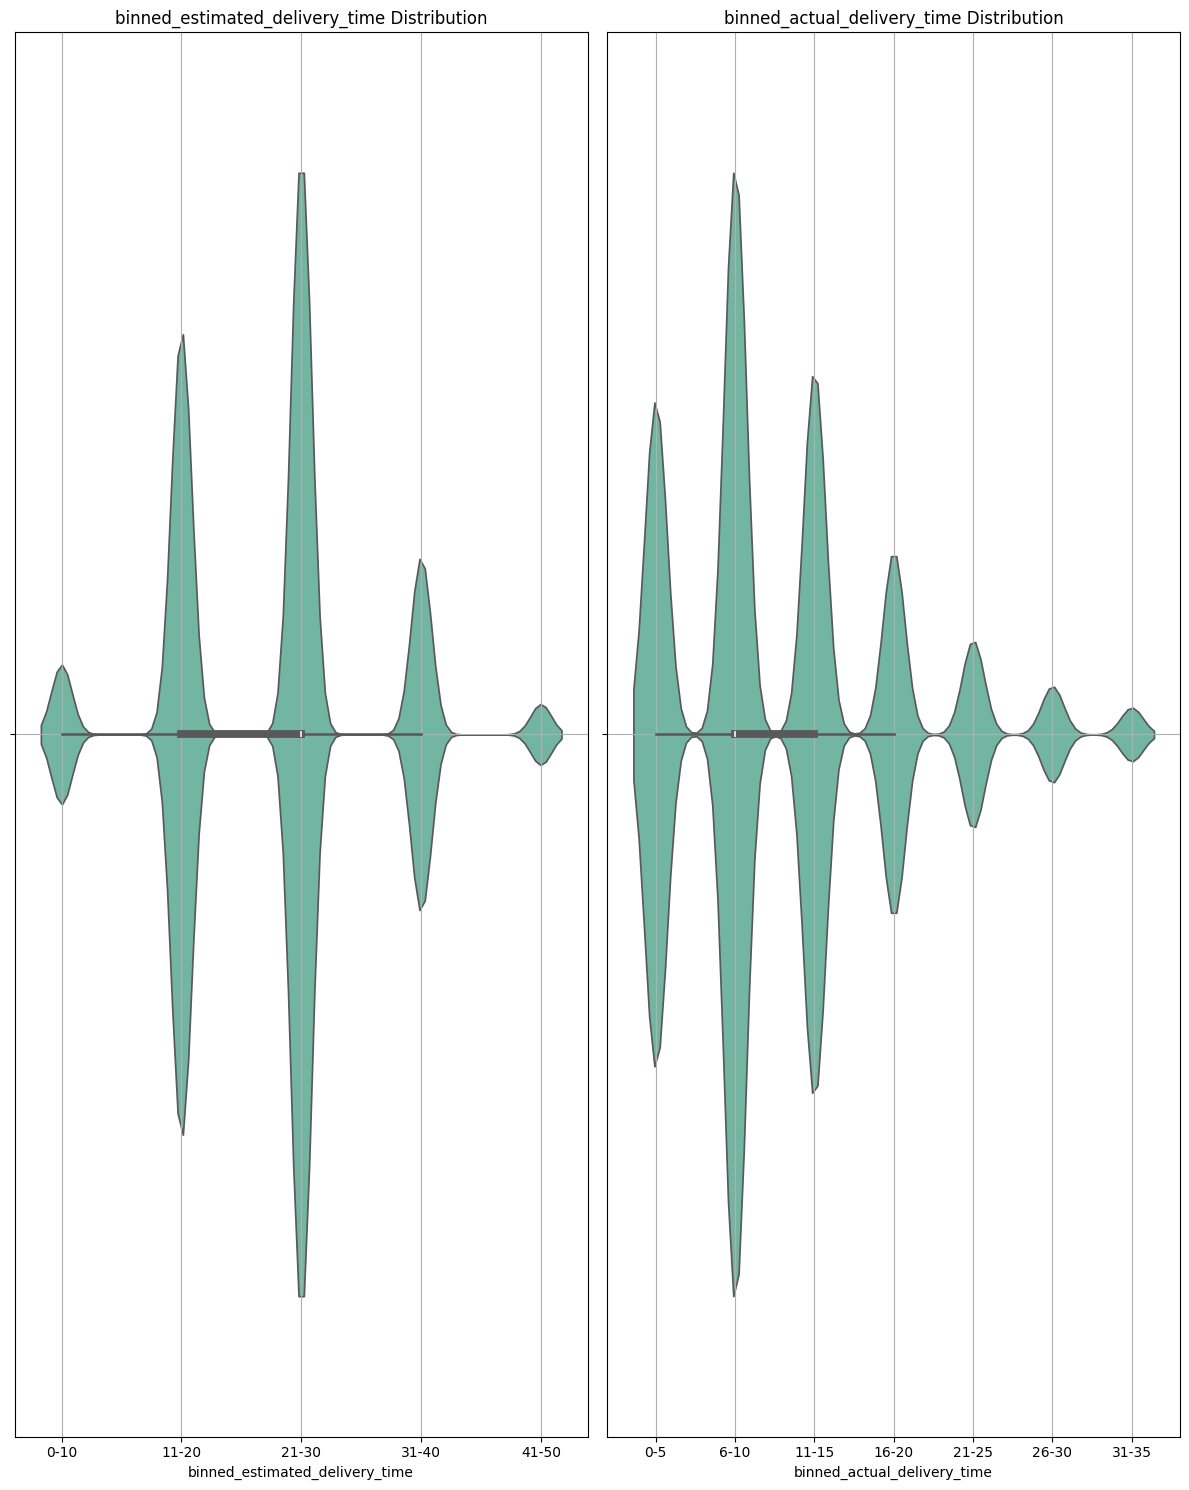

In [198]:
plot_feat = ['binned_estimated_delivery_time', 'binned_actual_delivery_time']

# we divide rows by 3 and make columns 3 to create the shape we want
fig, axes = plt.subplots(len(plot_feat)//2, 2, figsize=(12, 15))
axes = axes.flatten()

colors = sns.color_palette('Set2')

for i, col in enumerate(plot_feat):
    sns.violinplot(x=col, data=orders, ax=axes[i], palette=colors)
    axes[i].set_title(f'{col} Distribution')
    axes[i].grid(True)

if len(plot_feat) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In [199]:
actual_binned_upper = {
    '0-5': 5,
    '6-10': 10,
    '11-15': 15,
    '16-20': 20,
    '21-25': 25,
    '26-30': 30,
    '31-35': 35
}

est_binned_upper = {
    '0-10': 10,
    '11-20': 20,
    '21-30': 30,
    '31-40': 40,
    '41-50': 50
}

orders['binned_actual_delivery_time'] = orders['binned_actual_delivery_time'].map(actual_binned_upper)
orders['binned_estimated_delivery_time'] = orders['binned_estimated_delivery_time'].map(est_binned_upper)



In [200]:
orders['binned_actual_delivery_time'].value_counts()

binned_actual_delivery_time
10.0    32689
15.0    21000
5.0     19213
20.0    10547
25.0     5420
30.0     2777
35.0     1544
Name: count, dtype: int64

In [201]:
orders['binned_estimated_delivery_time'].value_counts()

binned_estimated_delivery_time
30.0    42823
20.0    29859
40.0    13093
10.0     5167
50.0     2248
Name: count, dtype: int64

#### Okay, all done with this dataset. We got all the data in the form we wanted for our model:
- product order timestamp as our univariate time measurement
- actual and est. delivery times as a discrete variable
- whether an order was late as a discrete variable
#### and handled some nice things for later
- handled some obvious outliers
- feature engineered three new descriptive features 
- binned columns for easier visualizations later with other datasets

### Lets move on to one of our other datasets.

In [202]:
# order_items
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


#### Things to do:
- sort by shipping limit date
- round price to nearest dollar

In [203]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


#### Things to do:
- change shipping_limit_date to a time dtype

In [204]:
order_items.describe(include='all')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
count,112650,112650.000000,112650,112650,112650,112650.000000,112650.000000
unique,98666,NaN,32951,3095,93318,NaN,NaN
top,8272b63d03f5f79c56e9e4120aec44ef,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23,NaN,NaN
freq,21,NaN,527,2033,21,NaN,NaN
mean,NaN,1.197834,NaN,NaN,NaN,120.653739,19.990320
std,NaN,0.705124,NaN,NaN,NaN,183.633928,15.806405
min,NaN,1.000000,NaN,NaN,NaN,0.850000,0.000000
25%,NaN,1.000000,NaN,NaN,NaN,39.900000,13.080000
50%,NaN,1.000000,NaN,NaN,NaN,74.990000,16.260000
75%,NaN,1.000000,NaN,NaN,NaN,134.900000,21.150000


#### Things to do:
- bin prices, freight value into price categories 
- set value to upper bound to create discrete variable 

In [205]:
order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'])
order_items = order_items.sort_values(by='shipping_limit_date')
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
101394,e5fa5a7210941f7d56d0208e4e071d35,1,f3c2d01a84c947b078e32bbef0718962,a425f92c199eb576938df686728acd20,2016-09-19 00:15:34,59.50,15.56
84389,bfbd0f9bdef84302105ad712db648a6c,1,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83
84390,bfbd0f9bdef84302105ad712db648a6c,2,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83
84391,bfbd0f9bdef84302105ad712db648a6c,3,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83
90368,cd3b8574c82b42fc8129f6d502690c3e,1,e2a1d45a73dc7f5a7f9236b043431b89,b499c00f28f4b7069ff6550af8c1348a,2016-10-08 10:34:01,29.99,10.96


In [206]:
order_items = order_items.rename(columns={
    'freight_value': 'shipping_cost',
    'shipping_limit_date': 'ship_deadline',
    'order_item_id': 'item_in_order'
})

order_items.head()

,order_id,item_in_order,product_id,seller_id,ship_deadline,price,shipping_cost
101394,e5fa5a7210941f7d56d0208e4e071d35,1,f3c2d01a84c947b078e32bbef0718962,a425f92c199eb576938df686728acd20,2016-09-19 00:15:34,59.50,15.56
84389,bfbd0f9bdef84302105ad712db648a6c,1,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83
84390,bfbd0f9bdef84302105ad712db648a6c,2,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83
84391,bfbd0f9bdef84302105ad712db648a6c,3,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83
90368,cd3b8574c82b42fc8129f6d502690c3e,1,e2a1d45a73dc7f5a7f9236b043431b89,b499c00f28f4b7069ff6550af8c1348a,2016-10-08 10:34:01,29.99,10.96


In [207]:
def round_price(price):
    cents = price - np.floor(price)
    return np.floor(price) if cents<.5 else np.ceil(price)

order_items['price'] = order_items['price'].apply(round_price).astype(int)
order_items['shipping_cost'] = order_items['shipping_cost'].apply(round_price).astype(int)

order_items.head()


,order_id,item_in_order,product_id,seller_id,ship_deadline,price,shipping_cost
101394,e5fa5a7210941f7d56d0208e4e071d35,1,f3c2d01a84c947b078e32bbef0718962,a425f92c199eb576938df686728acd20,2016-09-19 00:15:34,60,16
84389,bfbd0f9bdef84302105ad712db648a6c,1,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,45,3
84390,bfbd0f9bdef84302105ad712db648a6c,2,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,45,3
84391,bfbd0f9bdef84302105ad712db648a6c,3,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,45,3
90368,cd3b8574c82b42fc8129f6d502690c3e,1,e2a1d45a73dc7f5a7f9236b043431b89,b499c00f28f4b7069ff6550af8c1348a,2016-10-08 10:34:01,30,11


In [208]:
order_items.describe()

,item_in_order,ship_deadline,price,shipping_cost
count,112650.000000,112650,112650.000000,112650.000000
mean,1.197834,2018-01-07 15:36:52.192685312,120.701190,19.987492
min,1.000000,2016-09-19 00:15:34,1.000000,0.000000
25%,1.000000,2017-09-20 20:57:27.500000,40.000000,13.000000
50%,1.000000,2018-01-26 13:59:35,75.000000,16.000000
75%,1.000000,2018-05-10 14:34:00.750000128,135.000000,21.000000
max,21.000000,2020-04-09 22:35:08,6735.000000,410.000000
std,0.705124,NaN,183.628833,15.810237


/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/1233916722.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='price', data=order_items, palette='Set2', inner='box')


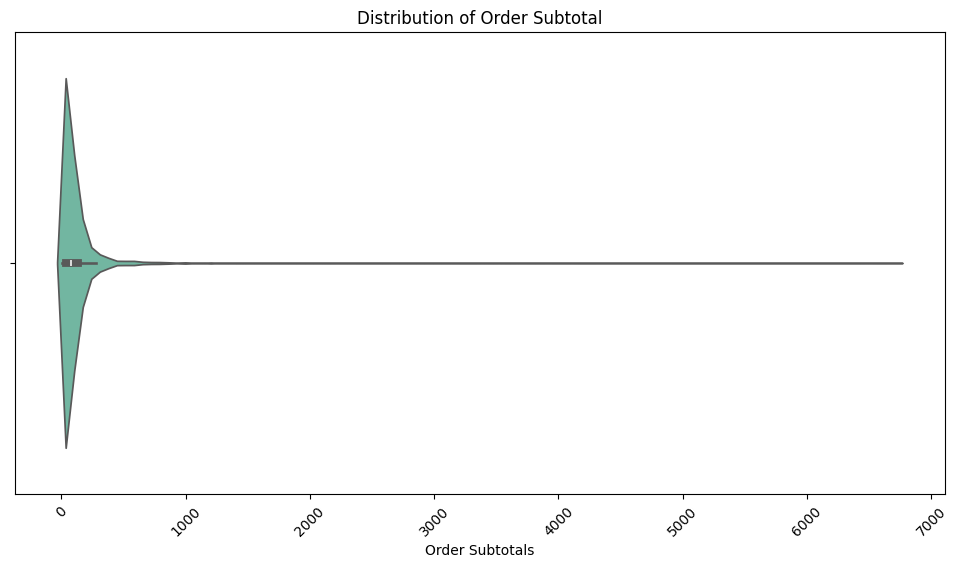

In [209]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='price', data=order_items, palette='Set2', inner='box')

plt.title('Distribution of Order Subtotal')
plt.xlabel('Order Subtotals')
plt.xticks(rotation=45)


plt.show()


/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/1997889356.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='shipping_cost', data=order_items, palette='Set2', inner='box')


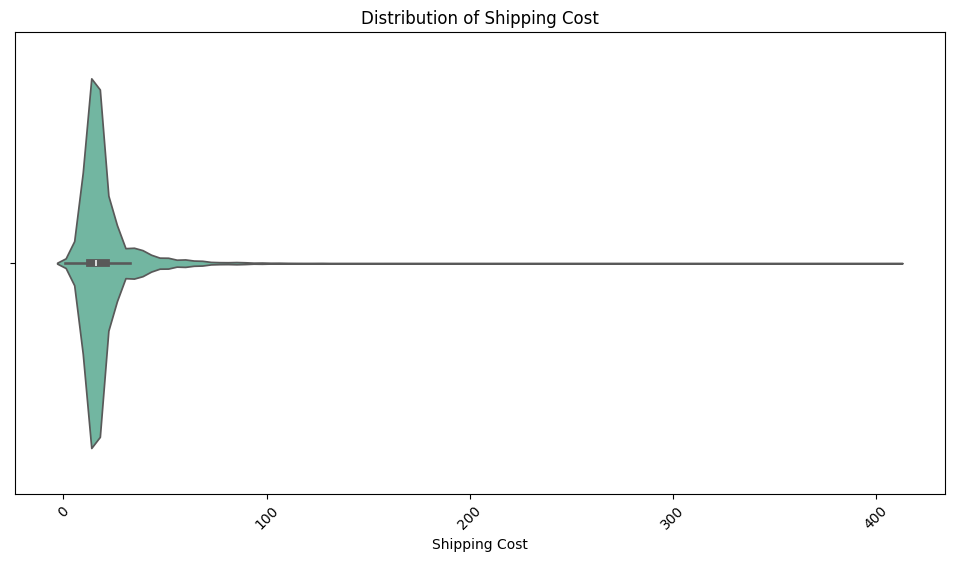

In [210]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='shipping_cost', data=order_items, palette='Set2', inner='box')

plt.title('Distribution of Shipping Cost')
plt.xlabel('Shipping Cost')
plt.xticks(rotation=45)


plt.show()

#### We can see most our orders are < ~$500, and almost all are < ~$800. Let's observe this closer.

In [211]:
order_subtotal_bins = [0, 10, 50, 100, 200, 500, float('inf')]
order_subtotal_labels= ['0-10', '11-50', '51-100', '101-200', '201-500', '500+']

freight_bins = [0, 10, 20, 40, 50, float('inf')]
freight_labels = ['0-10', '11-20', '21-40', '41-50', '50+']

order_items['price'] = pd.cut(order_items['price'], bins=order_subtotal_bins, labels=order_subtotal_labels, include_lowest=True)
order_items['shipping_cost'] = pd.cut(order_items['shipping_cost'], bins=freight_bins, labels=freight_labels, include_lowest=True)

order_items.head()



,order_id,item_in_order,product_id,seller_id,ship_deadline,price,shipping_cost
101394,e5fa5a7210941f7d56d0208e4e071d35,1,f3c2d01a84c947b078e32bbef0718962,a425f92c199eb576938df686728acd20,2016-09-19 00:15:34,51-100,11-20
84389,bfbd0f9bdef84302105ad712db648a6c,1,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,11-50,0-10
84390,bfbd0f9bdef84302105ad712db648a6c,2,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,11-50,0-10
84391,bfbd0f9bdef84302105ad712db648a6c,3,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,11-50,0-10
90368,cd3b8574c82b42fc8129f6d502690c3e,1,e2a1d45a73dc7f5a7f9236b043431b89,b499c00f28f4b7069ff6550af8c1348a,2016-10-08 10:34:01,11-50,11-20


/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/3673993615.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='price', data=order_items, palette='Set2', inner='box')


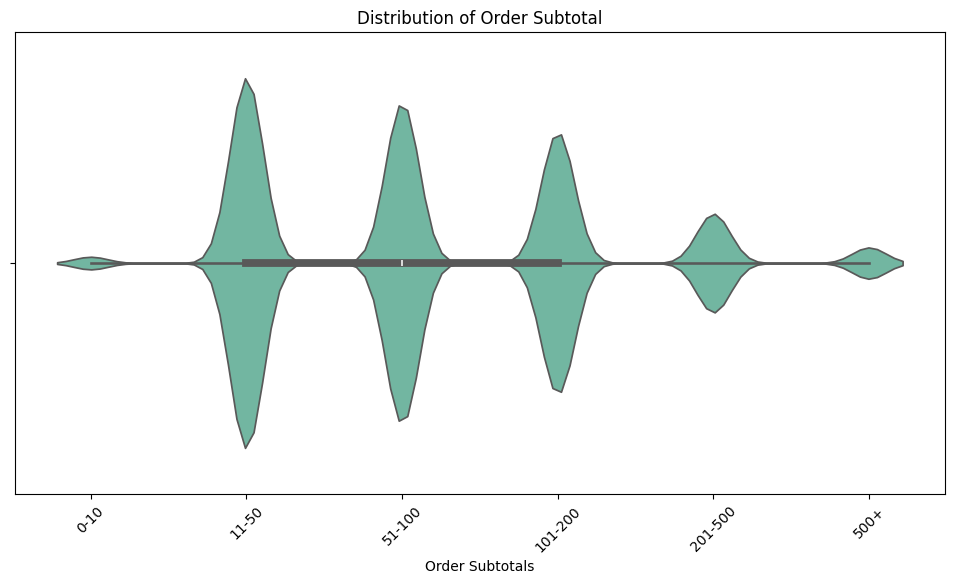

In [212]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='price', data=order_items, palette='Set2', inner='box')

plt.title('Distribution of Order Subtotal')
plt.xlabel('Order Subtotals')
plt.xticks(rotation=45)


plt.show()

/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/1997889356.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='shipping_cost', data=order_items, palette='Set2', inner='box')


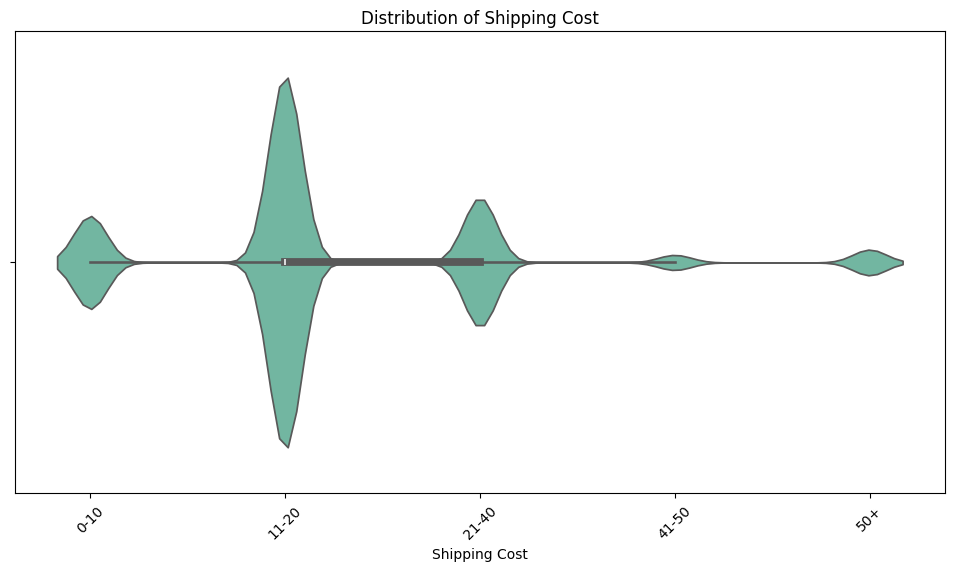

In [213]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='shipping_cost', data=order_items, palette='Set2', inner='box')

plt.title('Distribution of Shipping Cost')
plt.xlabel('Shipping Cost')
plt.xticks(rotation=45)


plt.show()

In [214]:
values_to_drop = ['50+', '41-50']
order_items = order_items[~order_items['shipping_cost'].isin(values_to_drop)]
order_items['shipping_cost'].value_counts()

shipping_cost
11-20    66128
21-40    22877
0-10     16438
41-50        0
50+          0
Name: count, dtype: int64

In [215]:
values_to_drop = ['500+']
order_items = order_items[~order_items['price'].isin(values_to_drop)]
order_items['price'].value_counts()

price
11-50      37683
51-100     31949
101-200    24372
201-500     8159
0-10        1297
500+           0
Name: count, dtype: int64

In [216]:
price_upper_bound = {
    '0-10': 10,
    '11-50': 50,
    '51-100': 100,
    '101-200': 200,
    '201-500': 500
}

freight_upper_bound = {
    '0-10': 10,
    '11-20': 20,
    '21-40': 40
}

order_items['price_mapped'] = order_items['price'].map(price_upper_bound)
order_items['shipping_cost_mapped'] = order_items['shipping_cost'].map(freight_upper_bound)

order_items.head()


,order_id,item_in_order,product_id,seller_id,ship_deadline,price,shipping_cost,price_mapped,shipping_cost_mapped
101394,e5fa5a7210941f7d56d0208e4e071d35,1,f3c2d01a84c947b078e32bbef0718962,a425f92c199eb576938df686728acd20,2016-09-19 00:15:34,51-100,11-20,100.0,20.0
84389,bfbd0f9bdef84302105ad712db648a6c,1,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,11-50,0-10,50.0,10.0
84390,bfbd0f9bdef84302105ad712db648a6c,2,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,11-50,0-10,50.0,10.0
84391,bfbd0f9bdef84302105ad712db648a6c,3,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,11-50,0-10,50.0,10.0
90368,cd3b8574c82b42fc8129f6d502690c3e,1,e2a1d45a73dc7f5a7f9236b043431b89,b499c00f28f4b7069ff6550af8c1348a,2016-10-08 10:34:01,11-50,11-20,50.0,20.0


/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/855887216.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='shipping_cost_mapped', data=order_items, palette='Set2', inner='box')


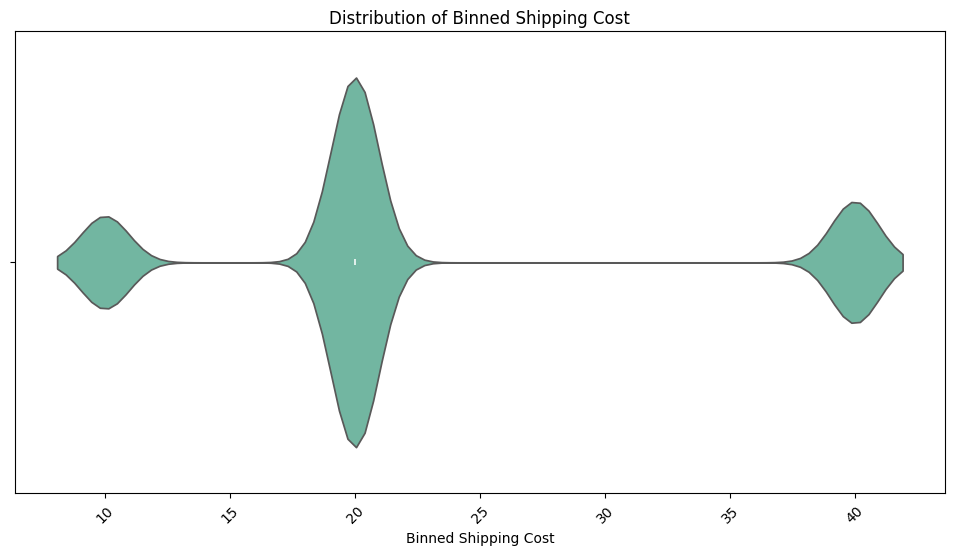

In [217]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='shipping_cost_mapped', data=order_items, palette='Set2', inner='box')

plt.title('Distribution of Binned Shipping Cost')
plt.xlabel('Binned Shipping Cost')
plt.xticks(rotation=45)


plt.show()

### Let look at products now 

In [218]:
products.head()

,product_id,product category,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,Art,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sport leisure,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,babies,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [219]:
products.describe(include='all')

,product_id,product category,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32951,32341,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
unique,32951,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1e9e8ef04dbcff4541ed26657ea517e5,bed table bath,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,3029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,NaN,NaN,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,NaN,NaN,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,NaN,NaN,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,NaN,NaN,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,NaN,NaN,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000


In [220]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product category            32341 non-null  object 
 2   product_name_length         32341 non-null  float64
 3   product_description_length  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


#### Things to do:
- delete missing/na rows
    - have enough data to get rid of na rows
- change dtypes to ints 
    - consistency
- delete columns besides weight, length, height, width
    - only care about these for our model
- examine outliers
    - see if we need to get rid of any outliers that are no good for our model



In [221]:
products.isna().sum()

product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [222]:
products_d = products.drop(columns=['product_name_length',
                    'product_description_length', 'product_photos_qty'])
products_d.isna().sum()

product_id             0
product category     610
product_weight_g       2
product_length_cm      2
product_height_cm      2
product_width_cm       2
dtype: int64

In [223]:
products_d = products_d.dropna()
products_d.isna().sum()

product_id           0
product category     0
product_weight_g     0
product_length_cm    0
product_height_cm    0
product_width_cm     0
dtype: int64

In [224]:
### Loop for assigning int to product category
def cat_to_int(df, column_name):
    product_cat_dict = {}
    counter = 0
    for index, row in df.iterrows():
        product_cat = row[column_name]
        if product_cat not in product_cat_dict:
            product_cat_dict[product_cat] = counter
            counter +=1
        df.at[index, f'{column_name} int'] = product_cat_dict[product_cat]
    print(product_cat_dict)
    return df, product_cat_dict

products_d, products_cat_dict = cat_to_int(products_d, 'product category')
print(products_cat_dict)
products_d.head()




{'perfumery': 0, 'Art': 1, 'sport leisure': 2, 'babies': 3, 'housewares': 4, 'musical instruments': 5, 'Cool Stuff': 6, 'Furniture Decoration': 7, 'home appliances': 8, 'toys': 9, 'bed table bath': 10, 'CONSTRUCTION SECURITY TOOLS': 11, 'computer accessories': 12, 'HEALTH BEAUTY': 13, 'Bags Accessories': 14, 'Garden tools': 15, 'Furniture office': 16, 'automotive': 17, 'electronics': 18, 'Fashion Calcados': 19, 'telephony': 20, 'stationary store': 21, 'Fashion Bags and Accessories': 22, 'PCs': 23, 'Casa Construcao': 24, 'Watches present': 25, 'Construction Tools Construction': 26, 'pet Shop': 27, 'electrostile': 28, 'Agro Industria e Comercio': 29, 'Room Furniture': 30, 'SIGNALIZATION AND SAFETY': 31, 'climatization': 32, 'Games consoles': 33, 'General Interest Books': 34, 'Construction Tools Tools': 35, 'Fashion Underwear and Beach Fashion': 36, "Fashion Men's Clothing": 37, 'Furniture Kitchen Service Area Dinner and Garden': 38, 'Industry Commerce and Business': 39, 'fixed telephony'

,product_id,product category,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product category int
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,225.0,16.0,10.0,14.0,0.0
1,3aa071139cb16b67ca9e5dea641aaa2f,Art,1000.0,30.0,18.0,20.0,1.0
2,96bd76ec8810374ed1b65e291975717f,sport leisure,154.0,18.0,9.0,15.0,2.0
3,cef67bcfe19066a932b7673e239eb23d,babies,371.0,26.0,4.0,26.0,3.0
4,9dc1a7de274444849c219cff195d0b71,housewares,625.0,20.0,17.0,13.0,4.0


In [225]:
products_d = products_d.drop(columns=['product category'])

products_d.head()

,product_id,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product category int
0,1e9e8ef04dbcff4541ed26657ea517e5,225.0,16.0,10.0,14.0,0.0
1,3aa071139cb16b67ca9e5dea641aaa2f,1000.0,30.0,18.0,20.0,1.0
2,96bd76ec8810374ed1b65e291975717f,154.0,18.0,9.0,15.0,2.0
3,cef67bcfe19066a932b7673e239eb23d,371.0,26.0,4.0,26.0,3.0
4,9dc1a7de274444849c219cff195d0b71,625.0,20.0,17.0,13.0,4.0


In [226]:
products_d['product_weight_g'] = products_d['product_weight_g'].astype(int)
products_d['product_height_cm'] = products_d['product_height_cm'].astype(int)
products_d['product_width_cm'] = products_d['product_width_cm'].astype(int)
products_d['product_length_cm'] = products_d['product_length_cm'].astype(int)
products_d['product category int'] = products_d['product category int'].astype(int)


products_d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32340 entries, 0 to 32950
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   product_id            32340 non-null  object
 1   product_weight_g      32340 non-null  int64 
 2   product_length_cm     32340 non-null  int64 
 3   product_height_cm     32340 non-null  int64 
 4   product_width_cm      32340 non-null  int64 
 5   product category int  32340 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 2.7+ MB


In [227]:
products_d.head()

,product_id,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product category int
0,1e9e8ef04dbcff4541ed26657ea517e5,225,16,10,14,0
1,3aa071139cb16b67ca9e5dea641aaa2f,1000,30,18,20,1
2,96bd76ec8810374ed1b65e291975717f,154,18,9,15,2
3,cef67bcfe19066a932b7673e239eb23d,371,26,4,26,3
4,9dc1a7de274444849c219cff195d0b71,625,20,17,13,4


In [228]:
products_d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32340 entries, 0 to 32950
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   product_id            32340 non-null  object
 1   product_weight_g      32340 non-null  int64 
 2   product_length_cm     32340 non-null  int64 
 3   product_height_cm     32340 non-null  int64 
 4   product_width_cm      32340 non-null  int64 
 5   product category int  32340 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 2.7+ MB


In [229]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96096 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               96096 non-null  object
 1   customer_unique_id        96096 non-null  object
 2   customer_zip_code_prefix  96096 non-null  int64 
 3   customer_city             96096 non-null  object
 4   customer_state            96096 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.4+ MB


In [230]:
customers, customers_city_dict = cat_to_int(customers, 'customer_city')
customers, customers_state_dict = cat_to_int(customers, 'customer_state')
print(customers_city_dict)
print(customers_state_dict)
customers.head()

/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/3641980506.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[index, f'{column_name} int'] = product_cat_dict[product_cat]


{'franca': 0, 'sao bernardo do campo': 1, 'sao paulo': 2, 'mogi das cruzes': 3, 'campinas': 4, 'jaragua do sul': 5, 'timoteo': 6, 'curitiba': 7, 'belo horizonte': 8, 'montes claros': 9, 'rio de janeiro': 10, 'lencois paulista': 11, 'caxias do sul': 12, 'piracicaba': 13, 'guarulhos': 14, 'pacaja': 15, 'florianopolis': 16, 'aparecida de goiania': 17, 'santo andre': 18, 'goiania': 19, 'cachoeiro de itapemirim': 20, 'sao jose dos campos': 21, 'sao roque': 22, 'camacari': 23, 'resende': 24, 'sumare': 25, 'novo hamburgo': 26, 'sao luis': 27, 'sao jose': 28, 'santa barbara': 29, 'ribeirao preto': 30, 'ituiutaba': 31, 'taquarituba': 32, 'sao jose dos pinhais': 33, 'barrinha': 34, 'parati': 35, 'dourados': 36, 'trindade': 37, 'cascavel': 38, 'fortaleza': 39, 'brasilia': 40, 'pelotas': 41, 'porto alegre': 42, 'salto': 43, 'jundiai': 44, 'cacapava': 45, 'sao vicente': 46, 'uberlandia': 47, 'botelhos': 48, 'sao goncalo': 49, 'araucaria': 50, 'nova iguacu': 51, 'areia branca': 52, 'campos dos goyta

/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/3641980506.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[index, f'{column_name} int'] = product_cat_dict[product_cat]


{'SP': 0, 'SC': 1, 'MG': 2, 'PR': 3, 'RJ': 4, 'RS': 5, 'PA': 6, 'GO': 7, 'ES': 8, 'BA': 9, 'MA': 10, 'MS': 11, 'CE': 12, 'DF': 13, 'RN': 14, 'PE': 15, 'MT': 16, 'AM': 17, 'AP': 18, 'AL': 19, 'RO': 20, 'PB': 21, 'TO': 22, 'PI': 23, 'AC': 24, 'SE': 25, 'RR': 26}
{'franca': 0, 'sao bernardo do campo': 1, 'sao paulo': 2, 'mogi das cruzes': 3, 'campinas': 4, 'jaragua do sul': 5, 'timoteo': 6, 'curitiba': 7, 'belo horizonte': 8, 'montes claros': 9, 'rio de janeiro': 10, 'lencois paulista': 11, 'caxias do sul': 12, 'piracicaba': 13, 'guarulhos': 14, 'pacaja': 15, 'florianopolis': 16, 'aparecida de goiania': 17, 'santo andre': 18, 'goiania': 19, 'cachoeiro de itapemirim': 20, 'sao jose dos campos': 21, 'sao roque': 22, 'camacari': 23, 'resende': 24, 'sumare': 25, 'novo hamburgo': 26, 'sao luis': 27, 'sao jose': 28, 'santa barbara': 29, 'ribeirao preto': 30, 'ituiutaba': 31, 'taquarituba': 32, 'sao jose dos pinhais': 33, 'barrinha': 34, 'parati': 35, 'dourados': 36, 'trindade': 37, 'cascavel': 

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_city int,customer_state int
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,0.0,0.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,1.0,0.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,2.0,0.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,3.0,0.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,4.0,0.0


In [231]:
customers = customers.drop(columns=['customer_city', 'customer_state'])
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city int,customer_state int
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,0.0,0.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,1.0,0.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,2.0,0.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,3.0,0.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,4.0,0.0


In [232]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93190 entries, 93285 to 88097
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   order_id                        93190 non-null  object        
 1   customer_id                     93190 non-null  object        
 2   order_status                    93190 non-null  object        
 3   order_purchase_timestamp        93190 non-null  datetime64[ns]
 4   order_approved_at               93190 non-null  datetime64[ns]
 5   order_delivered_carrier_date    93190 non-null  datetime64[ns]
 6   order_delivered_customer_date   93190 non-null  datetime64[ns]
 7   order_estimated_delivery_date   93190 non-null  datetime64[ns]
 8   actual_delivery_time            93190 non-null  int64         
 9   estimated_delivery_time         93190 non-null  int64         
 10  delivery_delay                  93190 non-null  int64         
 11  qua

In [233]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,actual_delivery_time,estimated_delivery_time,delivery_delay,quarter_label,binned_actual_delivery_time,binned_estimated_delivery_time
93285,3b697a20d9e427646d92567910af6d57,355077684019f7f60a031656bd7262b8,delivered,2016-10-03 09:44:50,2016-10-06 15:50:54,2016-10-23 14:02:13,2016-10-26 14:02:13,2016-10-27,23,23,0,Q4 2016,25.0,30.0
28424,be5bc2f0da14d8071e2d45451ad119d9,7ec40b22510fdbea1b08921dd39e63d8,delivered,2016-10-03 16:56:50,2016-10-06 16:03:44,2016-10-21 16:33:46,2016-10-27 18:19:38,2016-11-07,24,34,0,Q4 2016,25.0,40.0
88472,d207cc272675637bfed0062edffd0818,b8cf418e97ae795672d326288dfab7a7,delivered,2016-10-03 22:06:03,2016-10-04 10:28:07,2016-10-21 14:23:37,2016-10-31 11:07:42,2016-11-23,27,50,0,Q4 2016,30.0,50.0
6747,cd3b8574c82b42fc8129f6d502690c3e,7812fcebfc5e8065d31e1bb5f0017dae,delivered,2016-10-03 22:31:31,2016-10-04 10:19:23,2016-10-08 10:34:01,2016-10-14 16:08:00,2016-11-23,10,50,0,Q4 2016,10.0,50.0
78848,0a0837a5eee9e7a9ce2b1fa831944d27,4f3f778022aefa22b9f9e52d2c47edf3,delivered,2016-10-04 09:06:10,2016-10-06 11:43:20,2016-10-15 10:33:08,2016-10-22 14:51:18,2016-11-24,18,50,0,Q4 2016,20.0,50.0


In [234]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103460 entries, 101394 to 8643
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   order_id              103460 non-null  object        
 1   item_in_order         103460 non-null  int64         
 2   product_id            103460 non-null  object        
 3   seller_id             103460 non-null  object        
 4   ship_deadline         103460 non-null  datetime64[ns]
 5   price                 103460 non-null  category      
 6   shipping_cost         103460 non-null  category      
 7   price_mapped          103460 non-null  float64       
 8   shipping_cost_mapped  103460 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.5+ MB


In [235]:
order_items.head()

,order_id,item_in_order,product_id,seller_id,ship_deadline,price,shipping_cost,price_mapped,shipping_cost_mapped
101394,e5fa5a7210941f7d56d0208e4e071d35,1,f3c2d01a84c947b078e32bbef0718962,a425f92c199eb576938df686728acd20,2016-09-19 00:15:34,51-100,11-20,100.0,20.0
84389,bfbd0f9bdef84302105ad712db648a6c,1,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,11-50,0-10,50.0,10.0
84390,bfbd0f9bdef84302105ad712db648a6c,2,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,11-50,0-10,50.0,10.0
84391,bfbd0f9bdef84302105ad712db648a6c,3,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,11-50,0-10,50.0,10.0
90368,cd3b8574c82b42fc8129f6d502690c3e,1,e2a1d45a73dc7f5a7f9236b043431b89,b499c00f28f4b7069ff6550af8c1348a,2016-10-08 10:34:01,11-50,11-20,50.0,20.0


In [236]:
# inner keeps only rows where order_id in both dfs
# outer keeps all rows even if no match
# left keeps all rows from first df and matches w 2nd where possible
# right does opposite of left

merged_df = pd.merge(orders, order_items, on='order_id', how='inner')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98167 entries, 0 to 98166
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   order_id                        98167 non-null  object        
 1   customer_id                     98167 non-null  object        
 2   order_status                    98167 non-null  object        
 3   order_purchase_timestamp        98167 non-null  datetime64[ns]
 4   order_approved_at               98167 non-null  datetime64[ns]
 5   order_delivered_carrier_date    98167 non-null  datetime64[ns]
 6   order_delivered_customer_date   98167 non-null  datetime64[ns]
 7   order_estimated_delivery_date   98167 non-null  datetime64[ns]
 8   actual_delivery_time            98167 non-null  int64         
 9   estimated_delivery_time         98167 non-null  int64         
 10  delivery_delay                  98167 non-null  int64         
 11  qu

In [238]:
merged_df['price_mapped'] = merged_df['price_mapped'].astype(int)
merged_df['shipping_cost_mapped'] = merged_df['shipping_cost_mapped'].astype(int)
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98167 entries, 0 to 98166
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   order_id                        98167 non-null  object        
 1   customer_id                     98167 non-null  object        
 2   order_status                    98167 non-null  object        
 3   order_purchase_timestamp        98167 non-null  datetime64[ns]
 4   order_approved_at               98167 non-null  datetime64[ns]
 5   order_delivered_carrier_date    98167 non-null  datetime64[ns]
 6   order_delivered_customer_date   98167 non-null  datetime64[ns]
 7   order_estimated_delivery_date   98167 non-null  datetime64[ns]
 8   actual_delivery_time            98167 non-null  int64         
 9   estimated_delivery_time         98167 non-null  int64         
 10  delivery_delay                  98167 non-null  int64         
 11  qu

In [98]:
merged_df['binned_actual_delivery_time'] = merged_df['binned_actual_delivery_time'].astype(int)
merged_df['binned_estimated_delivery_time'] = merged_df['binned_estimated_delivery_time'].astype(int)
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98167 entries, 0 to 98166
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   order_id                        98167 non-null  object        
 1   customer_id                     98167 non-null  object        
 2   order_status                    98167 non-null  object        
 3   order_purchase_timestamp        98167 non-null  datetime64[ns]
 4   order_approved_at               98167 non-null  datetime64[ns]
 5   order_delivered_carrier_date    98167 non-null  datetime64[ns]
 6   order_delivered_customer_date   98167 non-null  datetime64[ns]
 7   order_estimated_delivery_date   98167 non-null  datetime64[ns]
 8   actual_delivery_time            98167 non-null  int64         
 9   estimated_delivery_time         98167 non-null  int64         
 10  delivery_delay                  98167 non-null  int64         
 11  qu

In [239]:
new_merged = pd.merge(merged_df, products_d, on='product_id', how='inner')
new_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96751 entries, 0 to 96750
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   order_id                        96751 non-null  object        
 1   customer_id                     96751 non-null  object        
 2   order_status                    96751 non-null  object        
 3   order_purchase_timestamp        96751 non-null  datetime64[ns]
 4   order_approved_at               96751 non-null  datetime64[ns]
 5   order_delivered_carrier_date    96751 non-null  datetime64[ns]
 6   order_delivered_customer_date   96751 non-null  datetime64[ns]
 7   order_estimated_delivery_date   96751 non-null  datetime64[ns]
 8   actual_delivery_time            96751 non-null  int64         
 9   estimated_delivery_time         96751 non-null  int64         
 10  delivery_delay                  96751 non-null  int64         
 11  qu

In [240]:
new_merged.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,actual_delivery_time,estimated_delivery_time,...,ship_deadline,price,shipping_cost,price_mapped,shipping_cost_mapped,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product category int
0,3b697a20d9e427646d92567910af6d57,355077684019f7f60a031656bd7262b8,delivered,2016-10-03 09:44:50,2016-10-06 15:50:54,2016-10-23 14:02:13,2016-10-26 14:02:13,2016-10-27,23,23,...,2016-10-21 16:27:20,11-50,11-20,50,20,300,16,16,16,25
1,be5bc2f0da14d8071e2d45451ad119d9,7ec40b22510fdbea1b08921dd39e63d8,delivered,2016-10-03 16:56:50,2016-10-06 16:03:44,2016-10-21 16:33:46,2016-10-27 18:19:38,2016-11-07,24,34,...,2016-10-21 16:33:46,11-50,11-20,50,20,400,16,16,16,2
2,d207cc272675637bfed0062edffd0818,b8cf418e97ae795672d326288dfab7a7,delivered,2016-10-03 22:06:03,2016-10-04 10:28:07,2016-10-21 14:23:37,2016-10-31 11:07:42,2016-11-23,27,50,...,2016-10-21 16:23:06,101-200,11-20,200,20,2050,40,11,34,7
3,cd3b8574c82b42fc8129f6d502690c3e,7812fcebfc5e8065d31e1bb5f0017dae,delivered,2016-10-03 22:31:31,2016-10-04 10:19:23,2016-10-08 10:34:01,2016-10-14 16:08:00,2016-11-23,10,50,...,2016-10-08 10:34:01,11-50,11-20,50,20,9000,16,5,33,19
4,1ff217aa612f6cd7c4255c9bfe931c8b,b3a9bf200375f53cc5c6991919c356fd,delivered,2016-10-04 09:16:33,2016-10-04 09:43:32,2016-10-21 16:33:45,2016-10-24 16:33:45,2016-11-24,20,50,...,2016-10-21 16:33:45,11-50,11-20,50,20,200,21,21,21,33


In [241]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96096 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               96096 non-null  object 
 1   customer_unique_id        96096 non-null  object 
 2   customer_zip_code_prefix  96096 non-null  int64  
 3   customer_city int         96096 non-null  float64
 4   customer_state int        96096 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 6.4+ MB


In [242]:
customers['customer city int'] = customers['customer_city int'].astype(int)
customers['customer state int'] = customers['customer_state int'].astype(int)
customers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96096 entries, 0 to 99440
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               96096 non-null  object 
 1   customer_unique_id        96096 non-null  object 
 2   customer_zip_code_prefix  96096 non-null  int64  
 3   customer_city int         96096 non-null  float64
 4   customer_state int        96096 non-null  float64
 5   customer city int         96096 non-null  int64  
 6   customer state int        96096 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 7.9+ MB


In [243]:
customers = customers.drop(columns=['customer_city int', 'customer_state int'])
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer city int,customer state int
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,0,0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,1,0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,2,0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,3,0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,4,0


In [246]:
new_merged = pd.merge(new_merged, customers, on='customer_id', how='inner')
new_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93215 entries, 0 to 93214
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   order_id                        93215 non-null  object        
 1   customer_id                     93215 non-null  object        
 2   order_status                    93215 non-null  object        
 3   order_purchase_timestamp        93215 non-null  datetime64[ns]
 4   order_approved_at               93215 non-null  datetime64[ns]
 5   order_delivered_carrier_date    93215 non-null  datetime64[ns]
 6   order_delivered_customer_date   93215 non-null  datetime64[ns]
 7   order_estimated_delivery_date   93215 non-null  datetime64[ns]
 8   actual_delivery_time            93215 non-null  int64         
 9   estimated_delivery_time         93215 non-null  int64         
 10  delivery_delay                  93215 non-null  int64         
 11  qu

In [247]:
# new_merged.info()
new_merged['delivery_delay'].nunique()

2

# Lets try to train a model

In [248]:
feature_columns = [
    'binned_estimated_delivery_time',
    'binned_actual_delivery_time',
    'price_mapped',
    'shipping_cost_mapped',
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm',
    'product category int',
    'customer_zip_code_prefix',
    'customer city int',
    'customer state int'    
]

X = new_merged[feature_columns]
y = new_merged['delivery_delay']
X.head()

,binned_estimated_delivery_time,binned_actual_delivery_time,price_mapped,shipping_cost_mapped,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product category int,customer_zip_code_prefix,customer city int,customer state int
0,40.0,25.0,50,20,400,16,16,16,2,98280,2153,5
1,50.0,30.0,200,20,2050,40,11,34,7,13185,114,0
2,50.0,10.0,50,20,9000,16,5,33,19,12030,278,0
3,50.0,20.0,50,20,200,21,21,21,33,4849,2,0
4,50.0,25.0,500,20,8600,29,50,25,32,30350,8,2


In [249]:
X.shape

(93215, 12)

In [250]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: delivery_delay, dtype: int64

In [128]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [251]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scale_cols = ['binned_actual_delivery_time', 'binned_estimated_delivery_time','price_mapped',
    'shipping_cost_mapped', 'product_weight_g', 'product_length_cm',
    'product_height_cm', 'product_width_cm', 'product category int',
    'customer_zip_code_prefix', 'customer city int', 'customer state int']
X[scale_cols] = scaler.fit_transform(X[scale_cols])

X = X.drop(columns=['order_status'])
X.head()

/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/404931297.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[scale_cols] = scaler.fit_transform(X[scale_cols])


KeyError: "['order_status'] not found in axis"

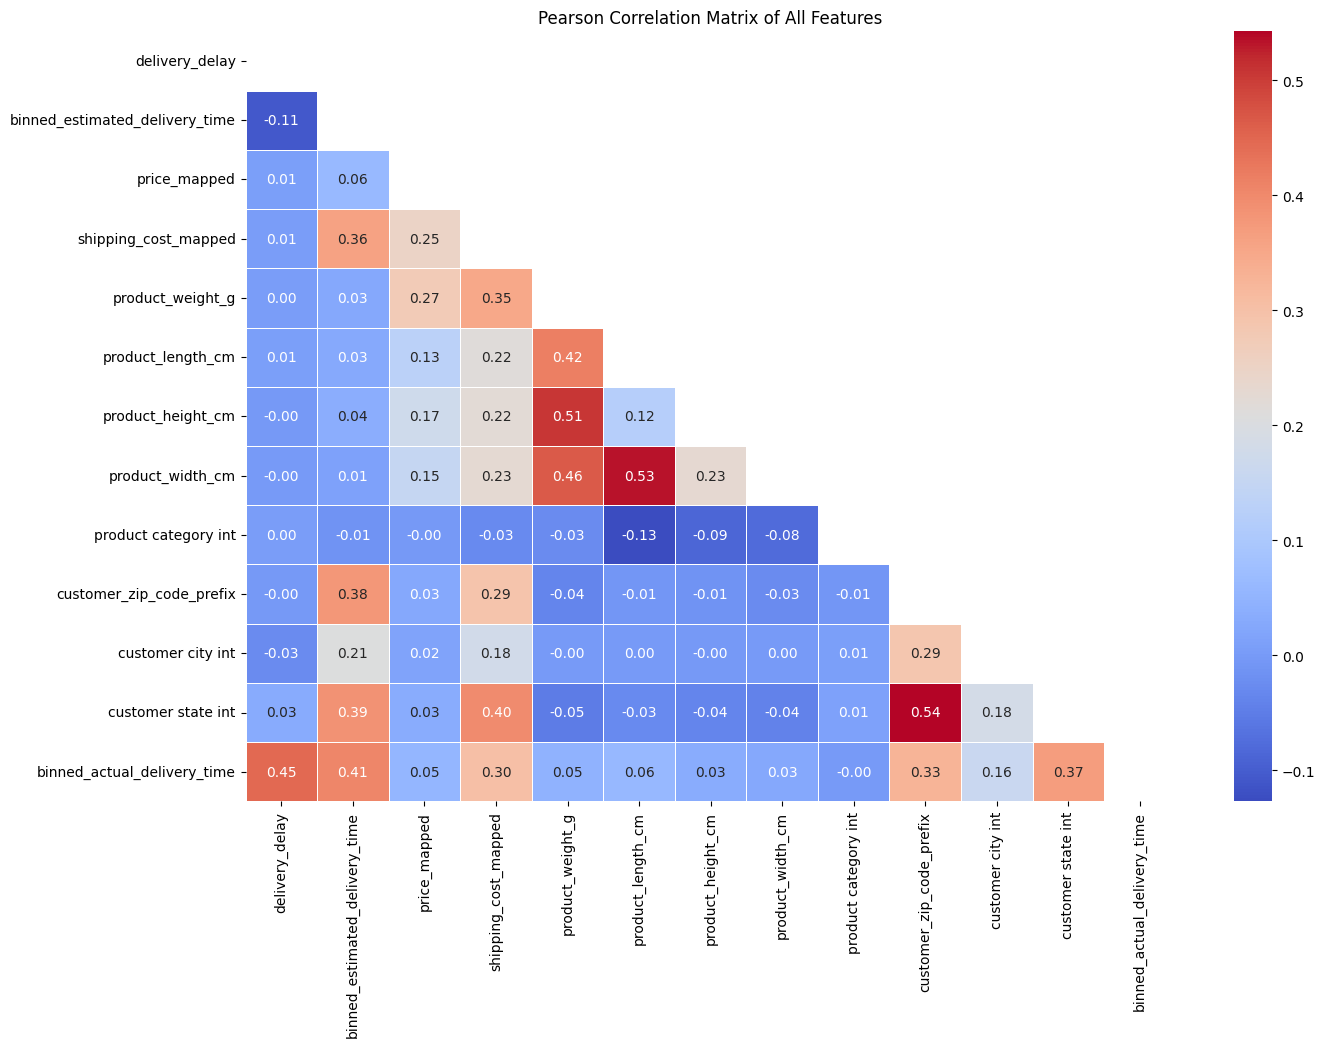

In [140]:
# We dont want to use highly coorelated features
pearson_corr_mat = pd.concat([X, y], axis=1).corr(method='pearson')

mask = np.triu(np.ones_like(pearson_corr_mat, dtype=bool))

plt.figure(figsize=(15, 10))
sns.heatmap(pearson_corr_mat, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5,
            annot_kws={'fontsize': 10}, mask=mask)
plt.title('Pearson Correlation Matrix of All Features')
plt.show()

#### None of our features seem too coorelated


/var/folders/9k/y_6tgpss1pgc415_60llvf9r0000gn/T/ipykernel_1355/1590452087.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


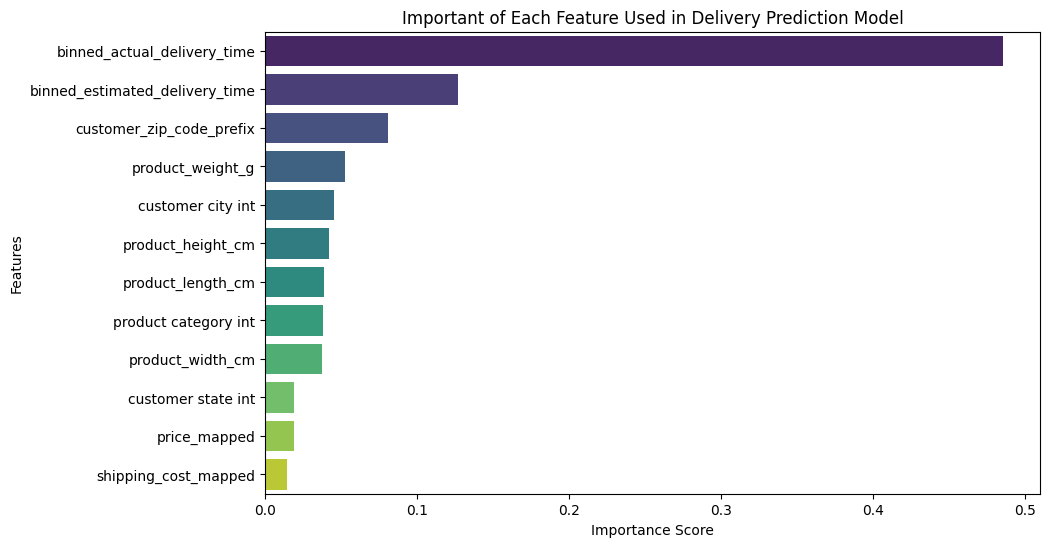

In [252]:
# fit and train model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rf_model = RandomForestClassifier(n_estimators=500)
rf_model.fit(X_train, y_train)

importance = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Important of Each Feature Used in Delivery Prediction Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


In [253]:
variance = X_train.var()
variance.sort_values(ascending=False)

shipping_cost_mapped              91.713543
product_weight_g                   3.913427
customer city int                  2.720142
binned_actual_delivery_time        1.837987
customer state int                 1.272413
product_height_cm                  0.949568
product category int               0.843506
binned_estimated_delivery_time     0.709649
product_length_cm                  0.705377
price_mapped                       0.649206
product_width_cm                   0.604661
customer_zip_code_prefix           0.452255
dtype: float64

In [254]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_auc_score

# define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, verbose=0),  # No verbosity
    'Random Forest': RandomForestClassifier(random_state=42, verbose=0),  # No verbosity
    'Support Vector Classifier': SVC(probability=True, verbose=False),  # No verbosity
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(verbose=0),  # No verbosity
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0),  # No verbosity
    'LightGBM': LGBMClassifier(verbose=-1),  # No verbosity
    'Naive Bayes': GaussianNB()  # Naive Bayes classifier
}

# 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# dictionary to store comparison
metrics_comparison = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': [], 'ROC AUC': []}

'''precision_scorer = make_scorer(precision_score, average='weighted')
recall_scorer = make_scorer(recall_score, average='weighted')
f1_scorer = make_scorer(f1_score, average='weighted')
roc_auc_scorer = make_scorer(roc_auc_score, multi_class='ovr')'''

# train models with 5-fold cross validation
num_models = len(models)
for i, (model_name, model) in enumerate(models.items()):
    accuracy_cv = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy').mean()
    precision_cv = cross_val_score(model, X_train, y_train, cv=kf, scoring='precision').mean()
    recall_cv = cross_val_score(model, X_train, y_train, cv=kf, scoring='recall').mean()
    f1_cv = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1').mean()
    roc_auc_cv = cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc').mean()

    model.fit(X_train, y_train,)

    y_pred_test = model.predict(X_test)
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]       # return prob of the prediction

    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    roc_aus_test = roc_auc_score(y_test, y_pred_proba_test)


    metrics_comparison['Model'].append(model_name)
    metrics_comparison['Accuracy'].append(f'CV: {accuracy_cv:.4f} | Test: {accuracy_test:.4f}')
    metrics_comparison['Precision'].append(f'CV: {precision_cv:.4f} | Test: {precision_test:.4f}')
    metrics_comparison['Recall'].append(f'CV: {recall_cv:.4f} | Test: {recall_test:.4f}')
    metrics_comparison['F1 Score'].append(f'CV: {f1_cv:.4f} | Test: {f1_test:.4f}')
    metrics_comparison['ROC AUC'].append(f'CV: {roc_auc_cv:.4f} | Test: {roc_aus_test:.4f}')

    percentage_complete = (i+1) / num_models * 100
    print(f'Completed {percentage_complete:.2f}% of evaluation.')

Completed 11.11% of evaluation.
Completed 22.22% of evaluation.
Completed 33.33% of evaluation.
Completed 44.44% of evaluation.
Completed 55.56% of evaluation.
Completed 66.67% of evaluation.
Completed 77.78% of evaluation.
Completed 88.89% of evaluation.
Completed 100.00% of evaluation.


In [255]:
metrics_comparison = pd.DataFrame(metrics_comparison)
metrics_comparison

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,CV: 0.9752 | Test: 0.9762,CV: 0.7969 | Test: 0.8059,CV: 0.7098 | Test: 0.7230,CV: 0.7508 | Test: 0.7622,CV: 0.9876 | Test: 0.9878
1,Random Forest,CV: 0.9797 | Test: 0.9812,CV: 0.8882 | Test: 0.8911,CV: 0.7029 | Test: 0.7332,CV: 0.7847 | Test: 0.8045,CV: 0.9854 | Test: 0.9868
2,Support Vector Classifier,CV: 0.9760 | Test: 0.9764,CV: 0.8796 | Test: 0.8774,CV: 0.6303 | Test: 0.6415,CV: 0.7343 | Test: 0.7412,CV: 0.9854 | Test: 0.9860
3,Decision Tree,CV: 0.9706 | Test: 0.9736,CV: 0.7148 | Test: 0.7477,CV: 0.7352 | Test: 0.7515,CV: 0.7248 | Test: 0.7496,CV: 0.8595 | Test: 0.8687
4,K-Nearest Neighbors,CV: 0.9704 | Test: 0.9712,CV: 0.8051 | Test: 0.7955,CV: 0.5789 | Test: 0.6100,CV: 0.6733 | Test: 0.6905,CV: 0.9194 | Test: 0.9267
5,Gradient Boosting,CV: 0.9779 | Test: 0.9785,CV: 0.8871 | Test: 0.8922,CV: 0.6642 | Test: 0.6741,CV: 0.7596 | Test: 0.7680,CV: 0.9886 | Test: 0.9895
6,XGBoost,CV: 0.9780 | Test: 0.9798,CV: 0.8572 | Test: 0.8739,CV: 0.6993 | Test: 0.7200,CV: 0.7702 | Test: 0.7895,CV: 0.9892 | Test: 0.9901
7,LightGBM,CV: 0.9784 | Test: 0.9798,CV: 0.8864 | Test: 0.8944,CV: 0.6772 | Test: 0.6986,CV: 0.7677 | Test: 0.7844,CV: 0.9896 | Test: 0.9901
8,Naive Bayes,CV: 0.9597 | Test: 0.9597,CV: 0.6600 | Test: 0.6624,CV: 0.4842 | Test: 0.4796,CV: 0.5585 | Test: 0.5564,CV: 0.9315 | Test: 0.9263


In [256]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'max_depth': [None, 10, 15, 20, 30],
    'n_estimators': [50, 100, 200, 500, 1000],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42, verbose=0)

random_search = RandomizedSearchCV(
    estimator = rf,
    param_distributions = param_dist,
    n_iter = 12,
    cv = 5,
    scoring='accuracy',
    verbose=1,
    n_jobs=1,
    random_state=42)
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': None}
